In [1]:
df = catalog.load('df_train')

2021-04-18 21:18:57,912 - kedro.io.data_catalog - INFO - Loading data from `df_train` (ParquetDataSet)...


In [2]:
categorical_cols = ['sex', 'residentialAddress_clean',
                    'postalAddress_clean', 'geo_risk_rank','shopID','same_address']
numerical_cols = ['age', 'income', 'price'] + \
    df.filter(regex='(^hist_)|(_lst_)').columns.to_list()

In [3]:
categorical_cols

['sex',
 'residentialAddress_clean',
 'postalAddress_clean',
 'geo_risk_rank',
 'shopID',
 'same_address']

In [4]:
numerical_cols

['age',
 'income',
 'price',
 'hist_trans_count',
 'hist_default_sum',
 'hist_default_avg',
 'hist_late_sum',
 'hist_late_avg',
 'hist_price_sum',
 'hist_price_avg',
 'default_lst_01_sum',
 'late_lst_01_sum',
 'price_lst_01_sum',
 'default_lst_01_avg',
 'late_lst_01_avg',
 'price_lst_01_avg',
 'default_lst_03_sum',
 'late_lst_03_sum',
 'price_lst_03_sum',
 'default_lst_03_avg',
 'late_lst_03_avg',
 'price_lst_03_avg',
 'default_lst_06_sum',
 'late_lst_06_sum',
 'price_lst_06_sum',
 'default_lst_06_avg',
 'late_lst_06_avg',
 'price_lst_06_avg',
 'default_lst_09_sum',
 'late_lst_09_sum',
 'price_lst_09_sum',
 'default_lst_09_avg',
 'late_lst_09_avg',
 'price_lst_09_avg',
 'default_lst_12_sum',
 'late_lst_12_sum',
 'price_lst_12_sum',
 'default_lst_12_avg',
 'late_lst_12_avg',
 'price_lst_12_avg']

# Category features

In [7]:
import numpy as np
from collections import Counter


In [17]:
def calculate_IV(column, default_column = 'default', default_val=1, nondefault_val=0, df=df, ifprt = True):
    """
    calculate IV - temporary implementation
    """
    total = df.shape[0]
    total_event = np.sum(df[default_column]==default_val)
    total_nonevent= np.sum(df[default_column]==nondefault_val)

    def total_prc(x): return np.round(len(x)/total,4)
    def event_prc(x): return  np.round(len([i for i in list(x) if i==default_val])/total_event,4)
    def nonevent_prc(x): return  np.round(len([i for i in list(x) if i==nondefault_val])/total_nonevent,4)
    def woe(x): return np.log(nonevent_prc(x)/(event_prc(x)+np.finfo(float).eps))
    def iv(x): return (nonevent_prc(x)-event_prc(x))*woe(x)

    wyn = df[[column,default_column]].groupby(column).agg(
        ['count',total_prc,event_prc, nonevent_prc, woe,iv
        ])

    if ifprt:
        print(wyn)
    IV = np.sum(wyn.iloc[:,-1])
    if ifprt:
        print("\n IV value of variable '{}' is {}".format(column,np.round(IV,4)))
    return IV, wyn

In [10]:
IV_cat = {}
repl_dic = {}

## Sex

In [19]:
IV_cat['sex'], repl_dic['sex'] = calculate_IV('sex', default_column='default')

       default                                                     
         count total_prc event_prc nonevent_prc       woe        iv
sex                                                                
female   61633    0.1999    0.3064       0.1892 -0.482087  0.056501
male    231229    0.7499    0.6161       0.7633  0.214242  0.031536
other    15485    0.0502    0.0775       0.0475 -0.489548  0.014686

 IV value of variable 'sex' is 0.1027


In [20]:
IV_cat['sex'], repl_dic['sex'] = calculate_IV('sex', default_column='late')

          late                                                     
         count total_prc event_prc nonevent_prc       woe        iv
sex                                                                
female   61633    0.1999    0.1550       0.2186  0.343818  0.021867
male    231229    0.7499    0.8062       0.7264 -0.104231  0.008318
other    15485    0.0502    0.0388       0.0550  0.348913  0.005652

 IV value of variable 'sex' is 0.0358


## geo_risk_rank

In [21]:
IV_cat['geo_risk_rank'], repl_dic['geo_risk_rank'] = calculate_IV('geo_risk_rank', default_column='default')

              default                                                     
                count total_prc event_prc nonevent_prc       woe        iv
geo_risk_rank                                                             
0               24782    0.0804    0.0692       0.0815  0.163602  0.002012
1               56853    0.1844    0.1674       0.1861  0.105898  0.001980
2               67958    0.2204    0.2168       0.2208  0.018282  0.000073
3               74057    0.2402    0.2411       0.2401 -0.004156  0.000004
4               59335    0.1924    0.2047       0.1912 -0.068225  0.000921
5               25362    0.0823    0.1008       0.0804 -0.226124  0.004613

 IV value of variable 'geo_risk_rank' is 0.0096


In [22]:
IV_cat['geo_risk_rank'], repl_dic['geo_risk_rank'] = calculate_IV('geo_risk_rank', default_column='late')

                late                                                         
               count total_prc event_prc nonevent_prc       woe            iv
geo_risk_rank                                                                
0              24782    0.0804    0.0810       0.0801 -0.011173  1.005597e-05
1              56853    0.1844    0.1854       0.1839 -0.008124  1.218528e-05
2              67958    0.2204    0.2203       0.2205  0.000907  1.814882e-07
3              74057    0.2402    0.2397       0.2404  0.002916  2.041243e-06
4              59335    0.1924    0.1930       0.1922 -0.004154  3.322954e-06
5              25362    0.0823    0.0806       0.0829  0.028136  6.471375e-05

 IV value of variable 'geo_risk_rank' is 0.0001


## same_address (postalAddress & residentialAddress)

In [23]:
IV_cat['same_address'], repl_dic['same_address'] = calculate_IV('same_address', default_column='default')

             default                                                     
               count total_prc event_prc nonevent_prc       woe        iv
same_address                                                             
0              21419    0.0695    0.2385       0.0525 -1.513556  0.281521
1             286928    0.9305    0.7615       0.9475  0.218537  0.040648

 IV value of variable 'same_address' is 0.3222


In [24]:
IV_cat['same_address'], repl_dic['same_address'] = calculate_IV('same_address', default_column='late')

                late                                                     
               count total_prc event_prc nonevent_prc       woe        iv
same_address                                                             
0              21419    0.0695    0.0619       0.0726  0.159445  0.001706
1             286928    0.9305    0.9381       0.9274 -0.011472  0.000123

 IV value of variable 'same_address' is 0.0018


## shopID

In [119]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.manifold import TSNE

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

In [44]:
set(clustering.labels_)

{-1, 0, 1, 2}

In [125]:
%matplotlib inline
shopID_pca = df.groupby('shopID').agg(
    default_rate=('default', 'mean'),
    age_avg=('age', 'mean'),
    price_avg=('price', 'mean'),
    income_avg=('income','mean')
)


scaler = MinMaxScaler()
X=scaler.fit_transform(shopID_pca)

#pc = PCA(n_components=2, random_state=1)
#X=pc.fit_transform(X)

X = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=300, random_state=1).fit_transform(X)


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 899 samples in 0.000s...
[t-SNE] Computed neighbors for 899 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 899 / 899
[t-SNE] Mean sigma: 0.079524
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.732620
[t-SNE] KL divergence after 300 iterations: 1.355151


<AxesSubplot:xlabel='x', ylabel='y'>

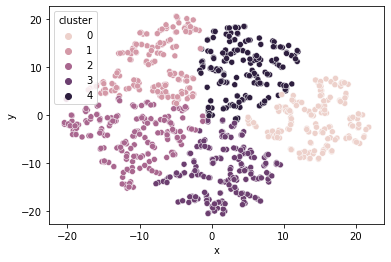

In [141]:
#clustering = DBSCAN(eps=0.07, min_samples=5).fit(X)
clustering = KMeans(n_clusters=5).fit(X)
set(clustering.labels_)

pca_clusters = pd.DataFrame(X, columns=['x','y']).assign(
    cluster=clustering.labels_, 
    dr=shopID_pca.default_rate)
sns.scatterplot(data=pca_clusters, x="x", y="y", hue="cluster")


In [142]:
shop_clusters = pd.DataFrame({'shopID':shopID_pca.index.to_list(), 'shop_cluster':clustering.labels_})
calculate_IV('shop_cluster', default_column='late', df=df.merge(shop_clusters, on='shopID', how='left'))

               late                                                         
              count total_prc event_prc nonevent_prc       woe            iv
shop_cluster                                                                
0             59638    0.1934    0.1922       0.1939  0.008806  1.497031e-05
1             56157    0.1821    0.1822       0.1821 -0.000549  5.489981e-08
2             67164    0.2178    0.2185       0.2175 -0.004587  4.587164e-06
3             65977    0.2140    0.2136       0.2141  0.002338  1.169044e-06
4             59411    0.1927    0.1934       0.1924 -0.005184  5.184045e-06

 IV value of variable 'shop_cluster' is 0.0


(2.596546456962523e-05,
                late                                                         
               count total_prc event_prc nonevent_prc       woe            iv
 shop_cluster                                                                
 0             59638    0.1934    0.1922       0.1939  0.008806  1.497031e-05
 1             56157    0.1821    0.1822       0.1821 -0.000549  5.489981e-08
 2             67164    0.2178    0.2185       0.2175 -0.004587  4.587164e-06
 3             65977    0.2140    0.2136       0.2141  0.002338  1.169044e-06
 4             59411    0.1927    0.1934       0.1924 -0.005184  5.184045e-06)

## residentialAddress_clean

In [163]:
residentialAddress_clean_pca = df.groupby('residentialAddress_clean').agg(
    default_rate=('default', 'mean'),
    age_avg=('age', 'mean'),
    price_avg=('price', 'mean'),
    income_avg=('income','mean')
)

scaler = MinMaxScaler()
X=scaler.fit_transform(residentialAddress_clean_pca)

X = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300, random_state=1).fit_transform(X)



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13260 samples in 0.005s...
[t-SNE] Computed neighbors for 13260 samples in 0.634s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13260
[t-SNE] Computed conditional probabilities for sample 2000 / 13260
[t-SNE] Computed conditional probabilities for sample 3000 / 13260
[t-SNE] Computed conditional probabilities for sample 4000 / 13260
[t-SNE] Computed conditional probabilities for sample 5000 / 13260
[t-SNE] Computed conditional probabilities for sample 6000 / 13260
[t-SNE] Computed conditional probabilities for sample 7000 / 13260
[t-SNE] Computed conditional probabilities for sample 8000 / 13260
[t-SNE] Computed conditional probabilities for sample 9000 / 13260
[t-SNE] Computed conditional probabilities for sample 10000 / 13260
[t-SNE] Computed conditional probabilities for sample 11000 / 13260
[t-SNE] Computed conditional probabilities for sample 12000 / 13260
[t-SNE] Computed conditional probabilities for sam

<AxesSubplot:xlabel='x', ylabel='y'>

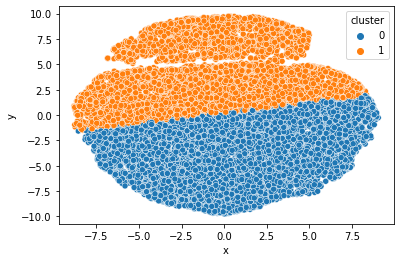

In [184]:
%matplotlib inline
#clustering = DBSCAN(eps=0.32, min_samples=10).fit(X)
clustering = KMeans(n_clusters=2).fit(X)
set(clustering.labels_)

pca_clusters = pd.DataFrame(X, columns=['x','y']).assign(
    cluster=clustering.labels_, 
    dr=residentialAddress_clean_pca.default_rate)
sns.scatterplot(data=pca_clusters, x="x", y="y", hue="cluster")



In [185]:
residentialAddress_clusters = pd.DataFrame({'residentialAddress_clean': residentialAddress_clean_pca.index.to_list(), 
              'residentialAddress_cluster':clustering.labels_})

calculate_IV('residentialAddress_cluster', default_column='late', df=df.merge(residentialAddress_clusters, on='residentialAddress_clean', how='left'))


                              late                                             \
                             count total_prc event_prc nonevent_prc       woe   
residentialAddress_cluster                                                      
0                           165548    0.5369    0.5278       0.5407  0.024147   
1                           142799    0.4631    0.4722       0.4593 -0.027699   

                                      
                                  iv  
residentialAddress_cluster            
0                           0.000311  
1                           0.000357  

 IV value of variable 'residentialAddress_cluster' is 0.0007


(0.0006688160527353597,
                               late                                             \
                              count total_prc event_prc nonevent_prc       woe   
 residentialAddress_cluster                                                      
 0                           165548    0.5369    0.5278       0.5407  0.024147   
 1                           142799    0.4631    0.4722       0.4593 -0.027699   
 
                                       
                                   iv  
 residentialAddress_cluster            
 0                           0.000311  
 1                           0.000357  )